In [19]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import urllib.parse
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
import ast
import json
from util_pcafa import *
from util_data import *

##### __SQL 연결__: 필요한 데이터 가져오기

In [20]:
# MySQL 연결 정보 설정
with open(f'./SQL_parameter.json', 'r') as file:
    par = json.load(file)

# MySQL 연결 정보 설정
host = par['host']
port = par['port']
username = par['username']
password = par['password']
database = par['database']

# 비밀번호 URL 인코딩
encoded_password = urllib.parse.quote_plus(password)

# SQLAlchemy 엔진 생성
engine = create_engine(f"mysql+pymysql://{username}:{encoded_password}@{host}:{port}/{database}")

query = "SELECT * FROM ad_gaze"
ad_gaze = pd.read_sql(query, engine)

query = "SELECT * FROM ad_info"
ad_info = pd.read_sql(query, engine)

query = "SELECT * FROM target"
ad_target = pd.read_sql(query, engine)
ad_target['target_info'] = ad_target['target_info'].apply(ast.literal_eval)

query = "SELECT * FROM frame"
frame = pd.read_sql(query, engine)

In [21]:
bins = [0, 20, 30, 40, 50, 60, float('inf')]
labels = ['10gen', '20gen', '30gen', '40gen', '50gen', '60gen']
ad_gaze['age_group'] = pd.cut(ad_gaze['pre_age'], 
                        bins=bins, 
                        labels=labels, 
                        right=False)

In [22]:
target = '탑마루' # 이후 리스트화 해서 반복문 거는 방향으로...
loc_num = 90
ad_id = ad_info[(ad_info['title']==target) & (ad_info['region_id']==loc_num)]['ad_id'].iloc[0]
frame_ids = frame[frame['ad_id']==ad_id]['id'].to_list()
ad_gt = ad_gaze[ad_gaze['frame_id'].isin(frame_ids)].copy() #adv_gt: adv_gaze_target
ad_gt.reset_index(drop='index', inplace=True)
ad_gt['gazed_num'] =  ad_gt['gazed'].cumsum()

In [23]:
pd.set_option('future.no_silent_downcasting', True)
data_pre = preprocessing_data(ad_gt)

#### __PCA__: 차원 축소를 위해 사용
- 누적 설명변수가 전체의 70% 이상이 되는 주성분 수 추출

In [24]:
cumm_evr, num, data_pre_, pca_df = apply_PCA(data_pre)
print(cumm_evr, num)

1 0.8207801061570276


#### __요인 분석__: gazed_num 값 변동에 주요인자로 작용하는 변수 탐색
- 각 변수 별 주성분 scatter로 시각화 (이건 그냥 보여주기용 필요 없음)
- scatter 상에서 gazed_num과 가장 가까운 변수들 위주로 선택

In [ ]:
# 요인분석
# 응시하는 보행자 분석결과 기반로 재추천 리스트 생성
recommand_target_df,fa_df = Apply_FA(cumm_evr, 0.8, data_pre_)

In [26]:
# 재추천 결과 출력을 위한 문자열 변환 함수
def format_age_groups(ages):
    return [age.replace('gen', '대') for age in ages if 'gen' in age]

def format_gender(list):
    if 'male' in list:
        return '남성'
    elif 'female' in list:
        return '여성'
    elif 'all' in list:
        return '모두'
    if ('male' in list) and ('female' in list):
        return '모두'
    if ('male' not in list) and ('female' not in list):
        return '모두'

In [27]:
target_id = ad_info['target_id'].iloc[0]
ad_target[ad_target['id']==target_id]['target_info']

0    [all, 10gen, 20gen, 30gen, 40gen, 50gen]
Name: target_info, dtype: object

In [28]:
raw_target = ad_target[ad_target['id']==target_id]['target_info'].iloc[0]
recommand_target = list(recommand_target_df.index)

In [29]:
display(recommand_target.index)
print(f"상품명: {target}")
print('\n')
print('설정된 광고대상')
print(f'성별: {format_gender(raw_target[0])}')
print(f'연령대: {", ".join(format_age_groups(raw_target))}')
print('\n')
print('추천 광고대상')
print(f'성별: {format_gender(recommand_target[0])}')
print(f'연령대: {", ".join(format_age_groups(recommand_target))}')

<function list.index(value, start=0, stop=9223372036854775807, /)>

상품명: 탑마루


설정된 광고대상
성별: 모두
연령대: 10대, 20대, 30대, 40대, 50대


추천 광고대상
성별: 남성
연령대: 10대, 20대, 30대, 40대, 50대, 60대


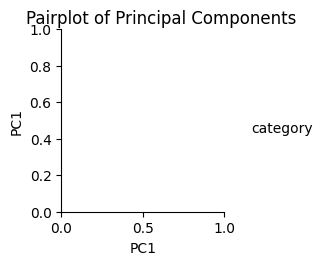

In [ ]:
fa_pairplot(fa_df)

In [31]:
fa_df

,PC1,distance
male,0.998057,0.046855
female,0.995703,0.044501
10gen,0.420826,0.530376
20gen,0.949811,0.001391
30gen,0.999983,0.048781
40gen,0.985610,0.034408
50gen,0.861474,0.089728
60gen,0.808846,0.142356
gaze_num,0.951202,0.000000
